In [161]:
# importation des modules nécessaires pour l'entrainement
# Basic
import os
from os import makedirs, listdir
from shutil import copyfile
from random import seed, random, sample
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Supression des alertes
import logging
logging.getLogger('tensorflow').disabled = True

In [138]:
# data import : dog
train_path = "C:\\Users\\joyce.mbiguidi\\Downloads\\dog_vs_cats\\train.zip"
test_path = "C:\\Users\\joyce.mbiguidi\\Downloads\\dog_vs_cats\\test1.zip"

dir = "C:\\Users\\joyce.mbiguidi\\Downloads\\dog_vs_cats\\"

import zipfile

with zipfile.ZipFile(train_path, "r") as zipp:
    zipp.extractall(dir)
    
with zipfile.ZipFile(test_path, "r") as zipp:
    zipp.extractall(dir)

In [139]:
# images overview in a dataframe
image_dir = dir + "train\\"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


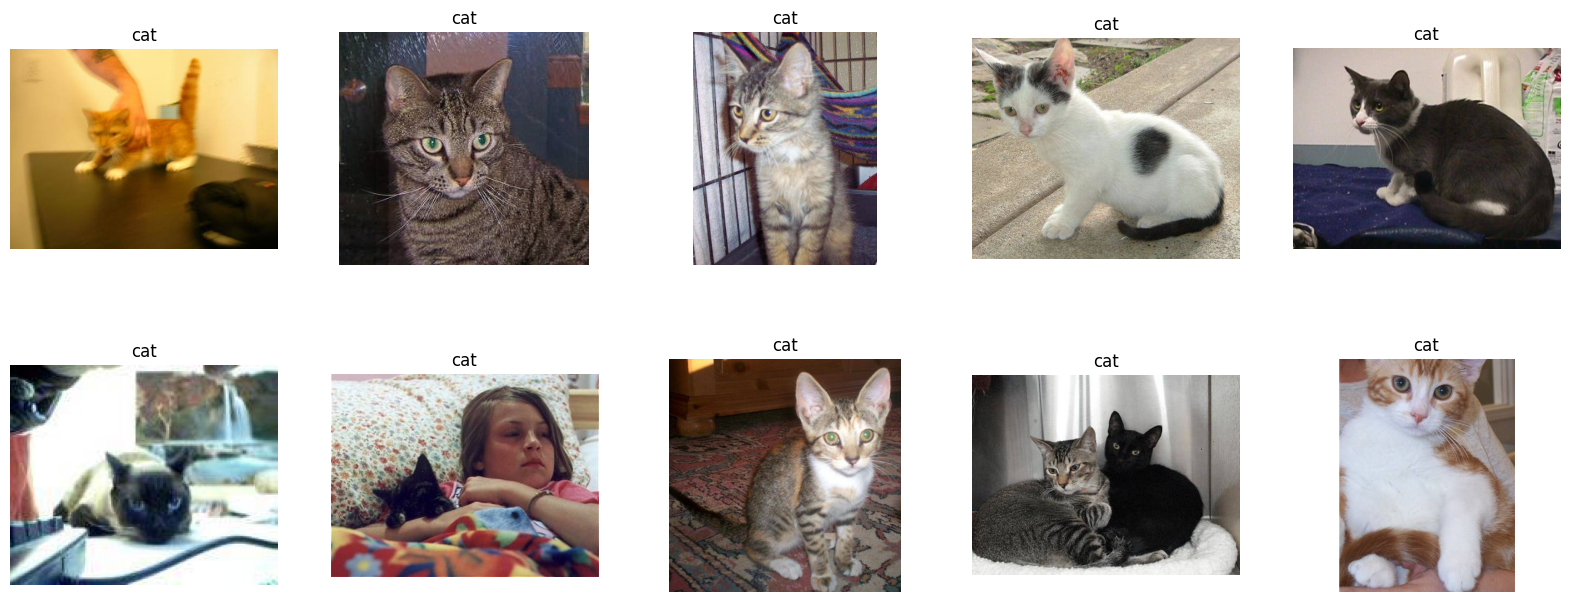

In [140]:
# lets vizualise cats
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):  
    plt.subplot(5,5,i+1)    # the number of images in the grid is 10*10 (100)
    filename = image_dir + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('cat',fontsize=12)
    plt.axis('off')

plt.show()

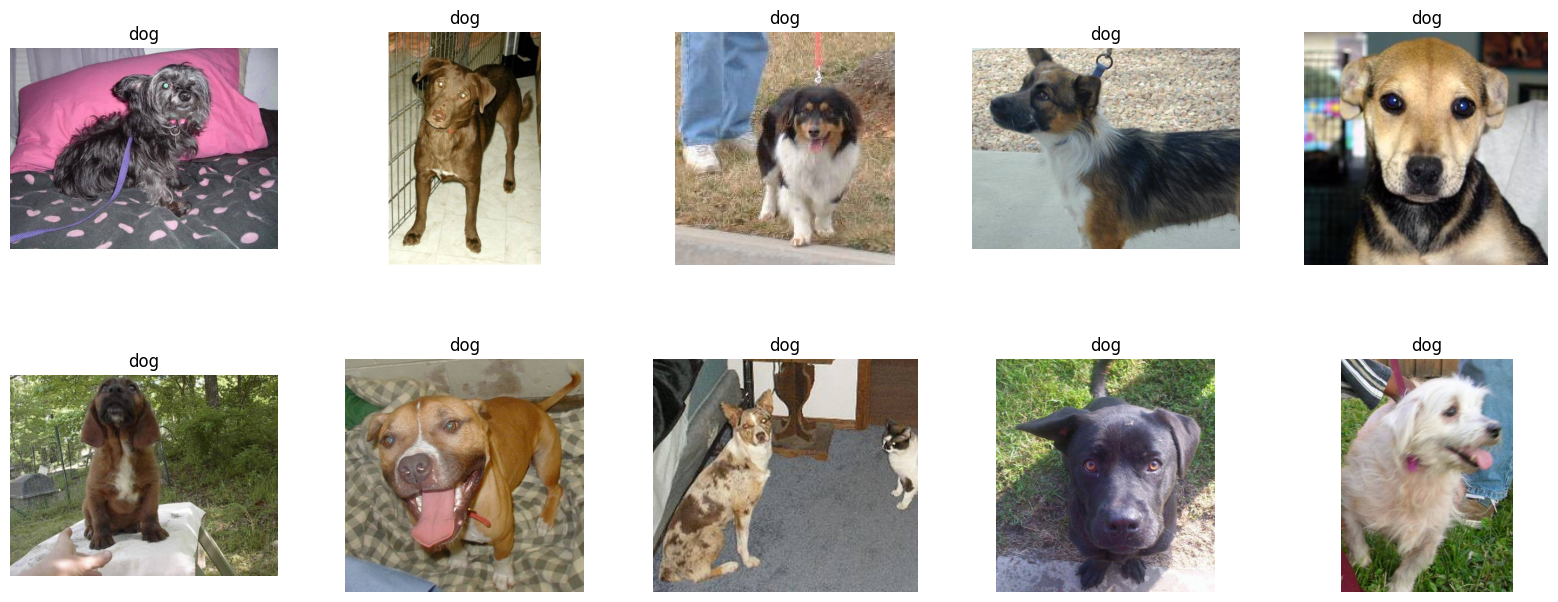

In [141]:
# lets vizualise dogs
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

from random import sample 
for i in range(10):  
    plt.subplot(5,5,i+1)    # the number of images in the grid is 10*10 (100)
    filename = image_dir + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('dog',fontsize=12)
    plt.axis('off')

plt.show()

In [142]:
# train test split : 80 -20
labels = data['label']
X_train, X_temp = train_test_split(data, test_size = 0.2, stratify = labels, random_state = 42, shuffle = True)

label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size = 0.5, stratify = label_test_val, random_state = 42, shuffle = True)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


In [143]:
# lets verify how good are labels balance
X_train_distribution = np.unique(X_train['label'], return_counts=True)
print('Class distribution : ', X_train_distribution)

X_val_distribution = np.unique(X_val['label'], return_counts=True)
print('Class distribution : ', X_val_distribution)

X_test_distribution = np.unique(X_test['label'], return_counts=True)
print('Class distribution : ', X_test_distribution)

Class distribution :  (array(['cat', 'dog'], dtype=object), array([10000, 10000], dtype=int64))
Class distribution :  (array(['cat', 'dog'], dtype=object), array([1250, 1250], dtype=int64))
Class distribution :  (array(['cat', 'dog'], dtype=object), array([1250, 1250], dtype=int64))


In [144]:
# parameters
image_size = 128
image_channel = 3
batch_size = 32

In [145]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [146]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir ,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = batch_size,
                                                    target_size = (image_size, image_size)
                                                   )

val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = image_dir,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = image_dir,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = batch_size,
                                                  target_size = (image_size, image_size),
                                                  shuffle=False
                                                 )


Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [147]:
# using directory
train_gen = train_datagen.flow_from_directory(dir + "train\\", 
                                              class_mode='binary',
                                              target_size = (image_size, image_size),
                                              batch_size = batch_size,
                                             )

val_gen = test_datagen.flow_from_directory(dir + "test1\\", 
                                          class_mode='binary',
                                          batch_size = batch_size,
                                          target_size = (image_size, image_size),
                                          shuffle = False
                                         )

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [148]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

model.summary()

c:\Users\joyce.mbiguidi\Documents\Github\Machine Learning\Python\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,514 (19.50 MB)

 Trainable params: 5,110,530 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

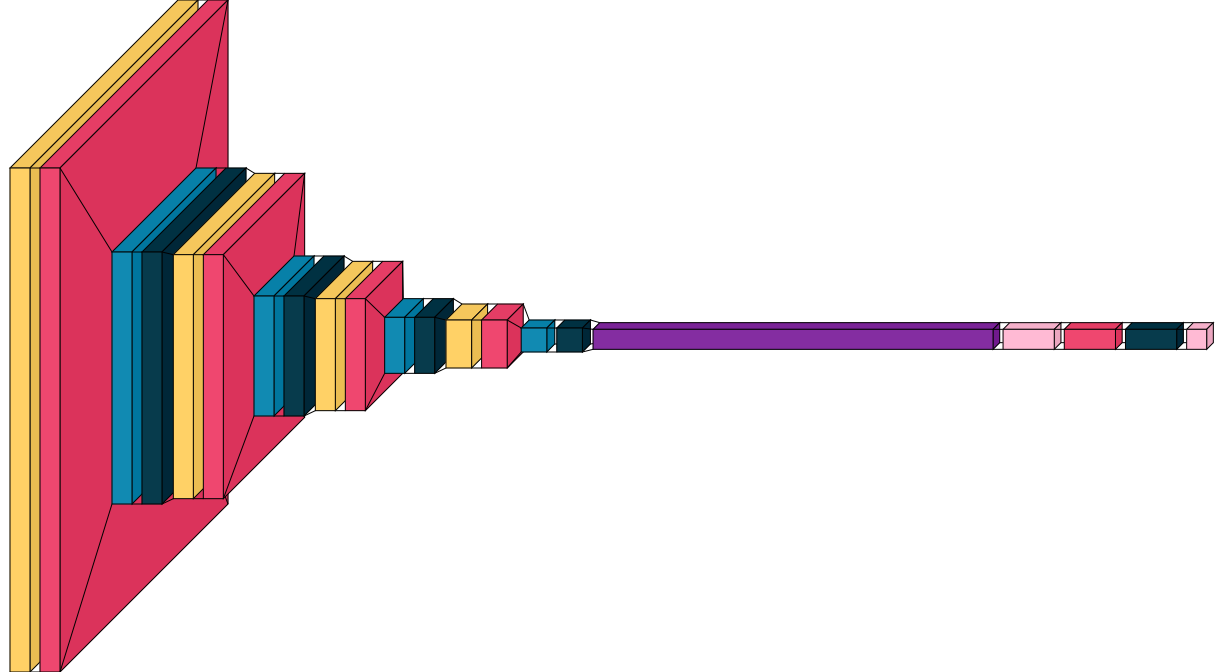

In [149]:
#!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show
visualkeras.layered_view(model)

In [152]:
# Define the callbacks
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=3)

In [153]:
# compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [154]:
# fit the model
cat_dog = model.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
                    epochs = 30,
                   )

Epoch 1/30


c:\Users\joyce.mbiguidi\Documents\Github\Machine Learning\Python\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 694s 1s/step - accuracy: 0.6386 - loss: 0.7401 - val_accuracy: 0.7176 - val_loss: 0.5661 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 376s 599ms/step - accuracy: 0.7222 - loss: 0.5505 - val_accuracy: 0.7744 - val_loss: 0.4969 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 369s 589ms/step - accuracy: 0.7910 - loss: 0.4532 - val_accuracy: 0.7604 - val_loss: 0.4990 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 372s 593ms/step - accuracy: 0.8147 - loss: 0.4059 - val_accuracy: 0.7956 - val_loss: 0.4785 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 368s 587ms/step - accuracy: 0.8296 - loss: 0.3759 - val_accuracy: 0.8508 - val_loss: 0.3287 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 377s 602ms/step - accuracy: 0.8613 - loss: 0.3255 - val_accuracy: 0.9048 - val_loss: 0.2260 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 386s 615ms/step - accuracy: 0.8671 - l

In [155]:
# Evaluvate for train generator
loss, acc = model.evaluate(train_generator,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for training data is:', acc*100)
print('The Loss of the model for training data is:', loss)

# Evaluvate for validation generator
loss, acc = model.evaluate(val_generator,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for validation data is:', acc*100)
print('The Loss of the model for validation data is:', loss)

The accuracy of the model for training data is: 92.98499822616577
The Loss of the model for training data is: 0.17215929925441742
The accuracy of the model for validation data is: 94.31999921798706
The Loss of the model for validation data is: 0.15449149906635284


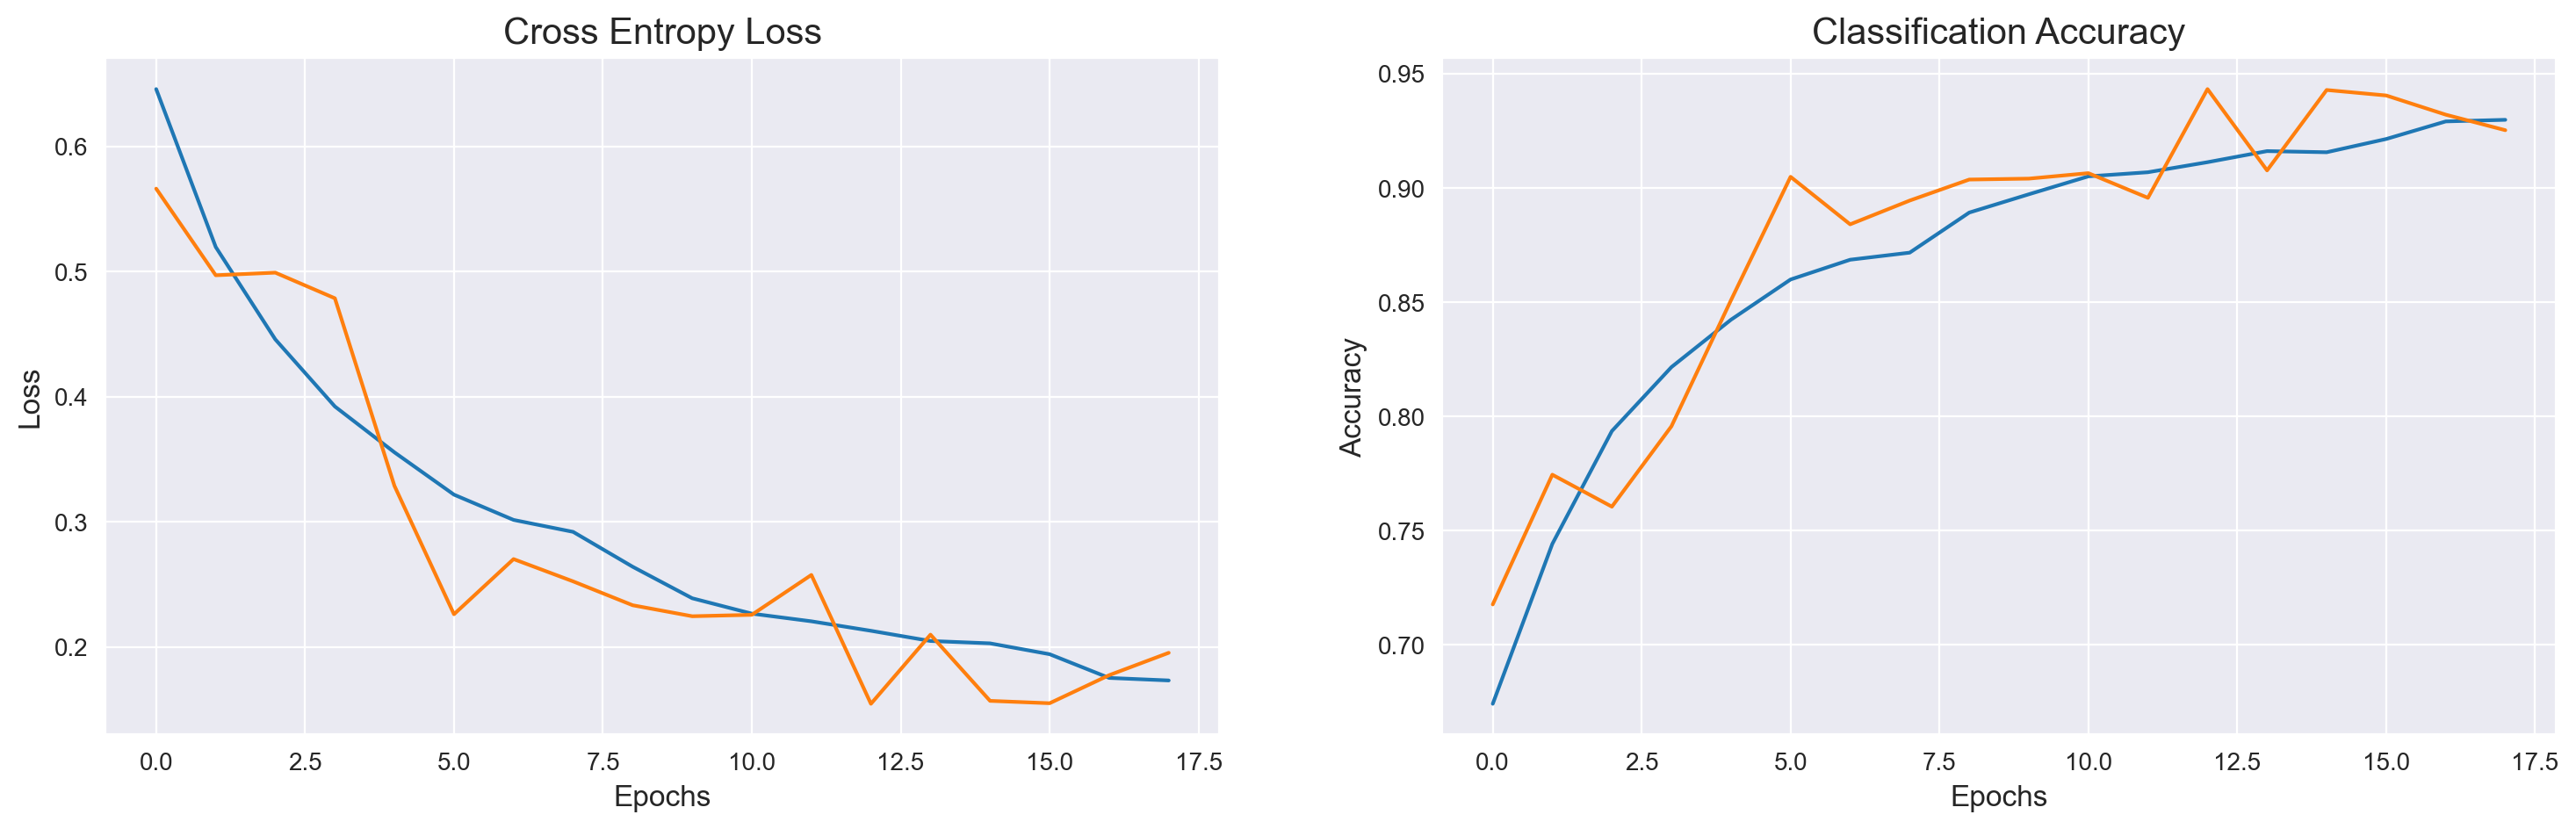

In [156]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [157]:
# prediction
result = model.predict(test_generator, batch_size = batch_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 94.08000111579895
The Loss of the model for testing data is: 0.1465216428041458


In [159]:
# classification report
labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

         Cat       0.93      0.96      0.94      1250
         Dog       0.96      0.92      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



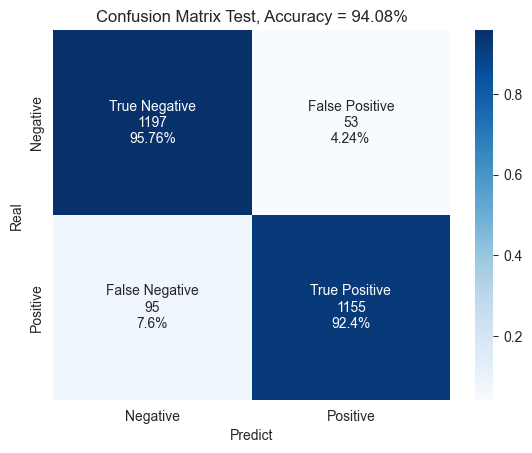

In [164]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_true, y_pred)
cm_train_perc = confusion_matrix(y_true, y_pred, normalize = 'true')

acc_score_train = accuracy_score(y_true, y_pred)

name = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = [cm_train[0][0], cm_train[0][1], cm_train[1][0], cm_train[1][1]]
percentage = [cm_train_perc[0][0]*100, cm_train_perc[0][1]*100, cm_train_perc[1][0]*100, cm_train_perc[1][1]*100]


boxlabels = [f"{n}\n{c}\n{p}%" for n,c,p in zip(name, counts, percentage)]
boxlabels = np.asarray(boxlabels).reshape(cm_train.shape[0],cm_train.shape[1])

#plt.figure(figsize = (12,10))
plt.title('Confusion Matrix Test, Accuracy = '+ str(acc_score_train*100)+ '%')

sns.heatmap(cm_train_perc, 
            cmap = 'Blues',
            xticklabels = ['Negative', 'Positive'],
            yticklabels = ['Negative', 'Positive'],
            fmt = '',
            annot = boxlabels)
    
plt.xlabel('Predict')
plt.ylabel('Real')

plt.show()
